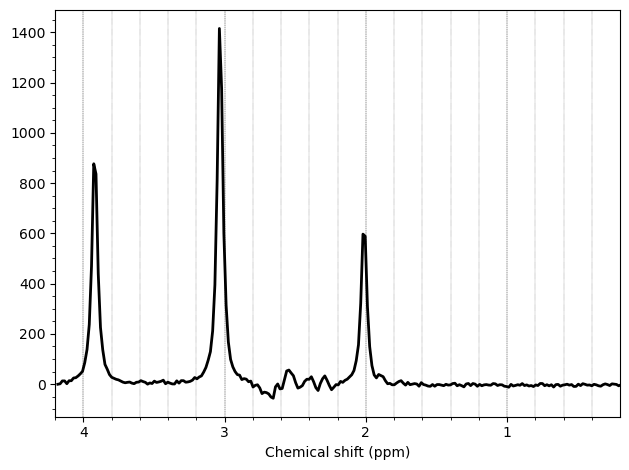

In [105]:
import numpy as np
import pandas as pd

from fsl_mrs.utils import mrs_io
from fsl_mrs.utils import synthetic as syn
from fsl_mrs.utils.fitting import fit_FSLModel
from fsl_mrs.core import MRS
from fsl_mrs import dynamic as dyn


basis_on = mrs_io.read_basis('basis_sets/uzay_svs_mpress_68_res_60_on/')
basis_off = mrs_io.read_basis('basis_sets/uzay_svs_mpress_68_res_60_off/')
basis_diff = mrs_io.read_basis('basis_sets/uzay_svs_mpress_68_res_60_diff/')

all_metabs = basis_on.names
ignore = [x for x in all_metabs if x not in ['NAA', 'GABA', 'Cr']]

def synthesize(basis, noise, lw, conc):
    synthesised = syn.synthetic_from_basis.syntheticFromBasisFile(
        basis,
        broadening=lw,
        noisecovariance=[[noise]],
        concentrations=conc,
        ignore=ignore,
        bandwidth=2000.0,
        points=1024)
    mrs = synthesised[1]
    mrs.FID = synthesised[0]
    concs_out = synthesised[2]
    return mrs, concs_out


def synthesize_diff(mrs_on, mrs_off):
    fid_diff = mrs_on.FID - mrs_off.FID\
         * (mrs_on.scaling['basis'] / mrs_off.scaling['basis'])
    mrs_diff = MRS(
        FID=fid_diff,
        cf=mrs_on.centralFrequency,
        bw=mrs_on.bandwidth,
        basis=basis_diff)
    mrs_diff.keep = ['NAA', 'GABA']
    mrs_diff.processForFitting()
    return mrs_diff


def run_iteration(lw, noise, cr_conc=4.87):

    # Create an instance of data:
    # 1. The ON condition
    syn_mrs_on, on_concs = synthesize(basis_on, noise, lw, {'GABA': 3.5, 'Cr': cr_conc})
    # 2. The OFF condition
    syn_mrs_off, _ = synthesize(basis_off, noise, lw, on_concs)
    # 3. The OFF condition, but double the acquisition time (sqrt(2) less noise)
    syn_mrs_off_equiv, _ = synthesize(basis_off, noise / np.sqrt(2), lw, on_concs)
    # 4. The difference spectrum
    syn_mrs_diff = synthesize_diff(syn_mrs_on, syn_mrs_off)

    # Run the fitting
    # Fitting options
    mg = [0, ] * len(on_concs)
    fitargs = {
        'model': 'lorentzian',
        'baseline_order': 0,
        'metab_groups': mg}
    fitargs_diff = {
        'model': 'lorentzian',
        'baseline_order': 0,
        'metab_groups': [0, ] * 2}

    # Run individual fits
    res_on = fit_FSLModel(syn_mrs_on, **fitargs,)
    # res_off = fit_FSLModel(syn_mrs_off, **fitargs)
    res_off_equiv = fit_FSLModel(syn_mrs_off_equiv, **fitargs)
    res_diff = fit_FSLModel(syn_mrs_diff, **fitargs_diff)

    on_off_to_diff_scaling = \
        (syn_mrs_diff.scaling['basis'] / syn_mrs_on.scaling['basis'])\
        * (syn_mrs_on.scaling['FID'] / syn_mrs_diff.scaling['FID'])

    # Extract individual concentration parameters
    df_res = pd.concat(
        (res_off_equiv.getConc(function=None),
         res_on.getConc(function=None),
         res_diff.getConc(function=None) * on_off_to_diff_scaling))
    df_res.set_index(
        np.array(['Off Matched', 'On', 'Diff']),
        inplace=True)

    # Run dynamic fitting
    mrs_list = [syn_mrs_off, syn_mrs_on]
    tvar = [0, 1]
    dyn_obj = dyn.dynMRS(
        mrs_list,
        tvar,
        'editconfig.py',
        rescale=False,
        **fitargs)
    init = dyn_obj.initialise(indiv_init=None)
    dyn_res = dyn_obj.fit(init=init)

    # Extract dynamic concentration parameters
    df_dyn = dyn_res.dataframe_free.filter(like='conc', axis=1)
    df_dyn.columns = df_res.columns
    df_dyn.set_index(np.array(['Dyn']), inplace=True)

    return pd.concat((df_res, df_dyn)),\
        {'dyn': dyn_res,
         'diff': (syn_mrs_diff, res_diff),
         'off': (syn_mrs_off_equiv, res_off_equiv)}

df_out, res_mrs = run_iteration((11.1, 0), 20, cr_conc=30)
res_mrs['off'][0].plot()

In [106]:
6*6*200*2.0/60/60

4.0

In [115]:
noise_levels = [4, 12, 36, 108, 324, 972]
cr_conc = [0, 5, 10, 15, 20, 30]
lw = 11.1
mc_reps = 200
df_container = []
n_array = []
cr_array = []
idx_array = []
for cr in cr_conc:
    for noise in noise_levels:
        for idx in range(mc_reps):
            n_array.append(noise)
            cr_array.append(cr)
            idx_array.append(idx)
            df_container.append(
                run_iteration(
                    (lw, 0),
                    noise,
                    cr_conc=cr)[0])


In [116]:
mi = pd.MultiIndex.from_arrays([cr_array, n_array, idx_array])
df = pd.concat(df_container, axis=0, keys=mi, names=['[Cr]', 'Noise SD', 'idx', 'method'])
gaba_sd = df.groupby(level=['[Cr]', 'Noise SD', 'method']).std()['GABA']

tmp = gaba_sd.unstack(level='method')

diff_off_ratio = (tmp['Diff']/tmp['Off Matched']).unstack()
dyn_off_ratio = (tmp['Dyn']/tmp['Off Matched']).unstack()
dyn_diff_ratio = (tmp['Dyn']/tmp['Diff']).unstack()
dyn_diff_ratio


Noise SD       4         12        36        108       324       972
[Cr]                                                                
0         0.614191  0.541103  0.596684  0.631816  0.661994  0.624292
5         0.701236  0.677865  0.730280  0.639196  0.631886  0.659419
10        0.634914  0.597251  0.695392  0.688290  0.637289  0.635481
15        0.608811  0.687273  0.626676  0.666302  0.622057  0.623113
20        0.628762  0.598180  0.681182  0.699798  0.580963  0.582148
30        0.592091  0.610089  0.636826  0.613168  0.656172  0.584407

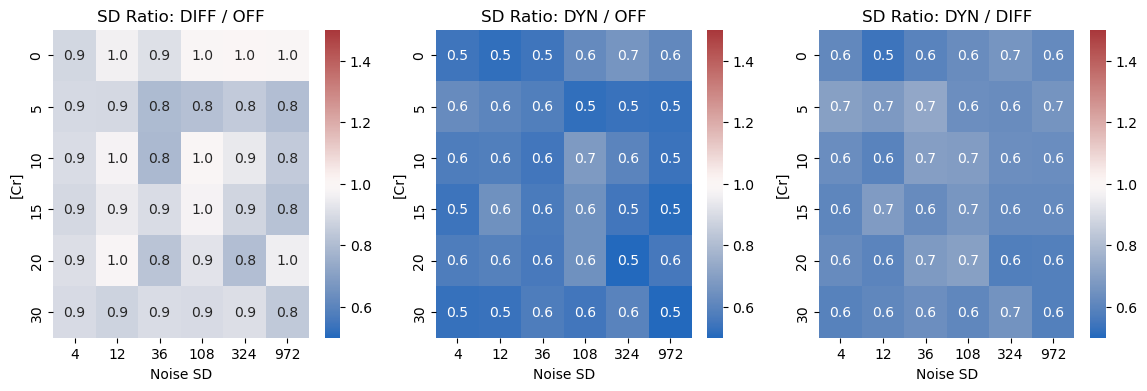

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
sns.heatmap(diff_off_ratio, ax=axes[0],annot=True, fmt=".1f", cmap='vlag', vmin=0.5, vmax=1.5)
sns.heatmap(dyn_off_ratio, ax=axes[1],annot=True, fmt=".1f", cmap='vlag', vmin=0.5, vmax=1.5)
sns.heatmap(dyn_diff_ratio, ax=axes[2],annot=True, fmt=".1f", cmap='vlag', vmin=0.5, vmax=1.5)
axes[0].set_title('SD Ratio: DIFF / OFF')
axes[1].set_title('SD Ratio: DYN / OFF')
axes[2].set_title('SD Ratio: DYN / DIFF')
plt.show()
# axes[0].imshow(diff_off_ratio.to_numpy(), vmin=0.5, vmax=2)

In [120]:
linewidths = [7.95, 11.1, 14.2, 20.5]
cr_conc = [0, 5, 10, 15, 20, 30]
mc_reps = 200
df_container2 = []
l_array = []
cr2_array = []
idx2_array = []
for cr in cr_conc:
    for lw in linewidths:
        for idx in range(mc_reps):
            l_array.append(lw)
            cr2_array.append(cr)
            idx2_array.append(idx)
            df_container2.append(
                run_iteration(
                    (lw, 0),
                    36,
                    cr_conc=cr)[0])


/Users/wclarke/Documents/Python/fsl_mrs/fsl_mrs/models/model_lorentzian.py:393: RuntimeWarning:

overflow encountered in exp

/Users/wclarke/Documents/Python/fsl_mrs/fsl_mrs/models/model_lorentzian.py:387: RuntimeWarning:

invalid value encountered in multiply

/Users/wclarke/Documents/Python/fsl_mrs/fsl_mrs/models/model_lorentzian.py:393: RuntimeWarning:

overflow encountered in exp

/Users/wclarke/Documents/Python/fsl_mrs/fsl_mrs/models/model_lorentzian.py:387: RuntimeWarning:

invalid value encountered in multiply



In [123]:
mi2 = pd.MultiIndex.from_arrays([cr2_array, l_array, idx2_array])
df2 = pd.concat(df_container2, axis=0, keys=mi2, names=['[Cr]', 'lw', 'idx', 'method'])
gaba_sd_lw = df2.groupby(level=['[Cr]', 'lw', 'method']).std()['GABA']

tmp = gaba_sd_lw.unstack(level='method')

diff_off_ratio_lw = (tmp['Diff']/tmp['Off Matched']).unstack()
dyn_off_ratio_lw = (tmp['Dyn']/tmp['Off Matched']).unstack()
dyn_diff_ratio_lw = (tmp['Dyn']/tmp['Diff']).unstack()
dyn_diff_ratio_lw


lw       7.95      11.10     14.20     20.50
[Cr]                                        
0     0.631143  0.571011  0.649256  0.578700
5     0.651596  0.644325  0.679388  0.562079
10    0.707267  0.713513  0.719318  0.618448
15    0.651868  0.662433  0.679983  0.620224
20    0.667321  0.657942  0.621031  0.584908
30    0.666883  0.634471  0.639744  0.573809

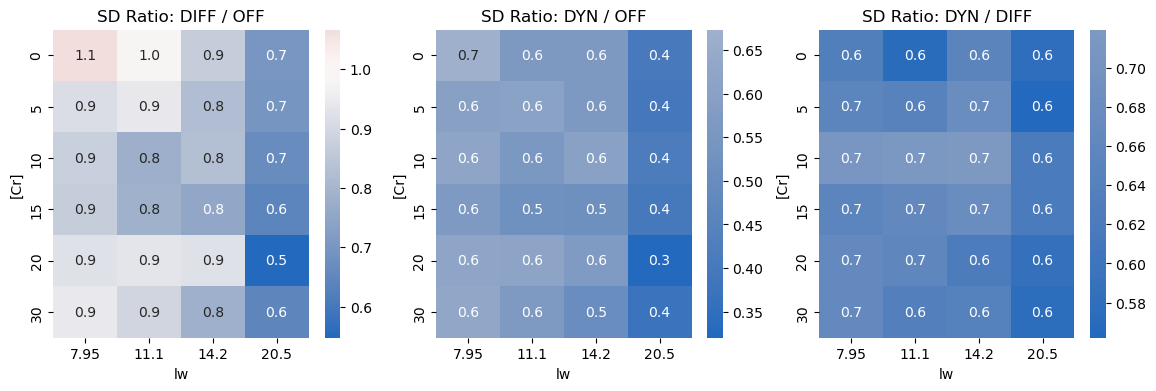

In [126]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
sns.heatmap(diff_off_ratio_lw, ax=axes[0],annot=True, fmt=".1f", cmap='vlag', center=1)
sns.heatmap(dyn_off_ratio_lw, ax=axes[1],annot=True, fmt=".1f", cmap='vlag', center=1)
sns.heatmap(dyn_diff_ratio_lw, ax=axes[2],annot=True, fmt=".1f", cmap='vlag', center=1)
axes[0].set_title('SD Ratio: DIFF / OFF')
axes[1].set_title('SD Ratio: DYN / OFF')
axes[2].set_title('SD Ratio: DYN / DIFF')
plt.show()
# axes[0].imshow(diff_off_ratio.to_numpy(), vmin=0.5, vmax=2)